In [2]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


In [3]:

df=pd.read_csv("mtbs_tropical_annotations.tsv", sep="\t")

#take the interested columns and make a new dataframe cleaned
df_cleaned= df_small = df[[
    "structure_smiles",
    "structure_taxonomy_npclassifier_01pathway",
    "structure_taxonomy_npclassifier_02superclass",
    "structure_taxonomy_npclassifier_03class"
]]


#remove rows with missing structure_smiles
df_cleaned = df.dropna(subset=["structure_smiles"], axis=0)

#check for duplicated smiles
df_cleaned.duplicated(subset=["structure_smiles"]).sum()

#collapse duplicate smiles by taking the most common class, subclass, my_class
def take_most_common(series: pd.Series):
    s = series.dropna()
    if s.empty:
        return np.nan
    return s.value_counts().idxmax()

#rename columns for easier handling
df_cleaned = df_cleaned.rename(columns={
    "structure_smiles": "smiles",
    "structure_taxonomy_npclassifier_01pathway": "class",
    "structure_taxonomy_npclassifier_02superclass": "subclass",
    "structure_taxonomy_npclassifier_03class": "my_class"
})

#collapse duplicates
df_collapsed = (
    df_cleaned
    .groupby("smiles", as_index=False)[["class", "subclass", "my_class"]]
    .agg(take_most_common)
)

#now I give an id to each smiles as in R code 
df_collapsed["SID"] = ["S" + str(i+1) for i in range(len(df_collapsed))]
df_collapsed = df_collapsed[["SID", "smiles", "class", "subclass", "my_class"]]


#calculate chemical descriptors
def calc_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "RingCount": Descriptors.RingCount(mol),
        "FractionCSP3": Descriptors.FractionCSP3(mol)
    }

desc_list = df_collapsed["smiles"].apply(calc_desc)
desc_df = pd.DataFrame(desc_list.tolist())
df_final = pd.concat([df_collapsed, desc_df], axis=1)




In [ ]:
#export final dataframe to csv
df_final.to_csv("mtbs_tropical_descriptors.csv", index=False)

In [4]:
df_final.head()

,SID,smiles,class,subclass,my_class,MolWt,LogP,TPSA,HBD,HBA,RingCount,FractionCSP3
0,S1,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,Fatty acyls,Fatty alcohols,292.466,5.8258,0.00,0,0,0,0.454545
1,S2,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,Fatty acyls|Fatty Acids and Conjugates,Fatty alcohols|Unsaturated fatty acids,282.471,5.8837,0.00,0,0,0,0.619048
2,S3,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,Fatty acyls,Fatty alcohols,308.465,4.4694,20.23,1,1,0,0.545455
3,S4,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,Lysine alkaloids,Piperidine alkaloids,297.442,4.0885,20.31,0,1,1,0.550000
4,S5,C#CC#CC=CC=CC=CCCO,Fatty acids,Fatty Acids and Conjugates,Unsaturated fatty acids,172.227,1.6740,20.23,1,1,0,0.166667


/var/folders/nm/01cqfvgn1655c0dthf5dhh900000gn/T/ipykernel_6003/2760016068.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


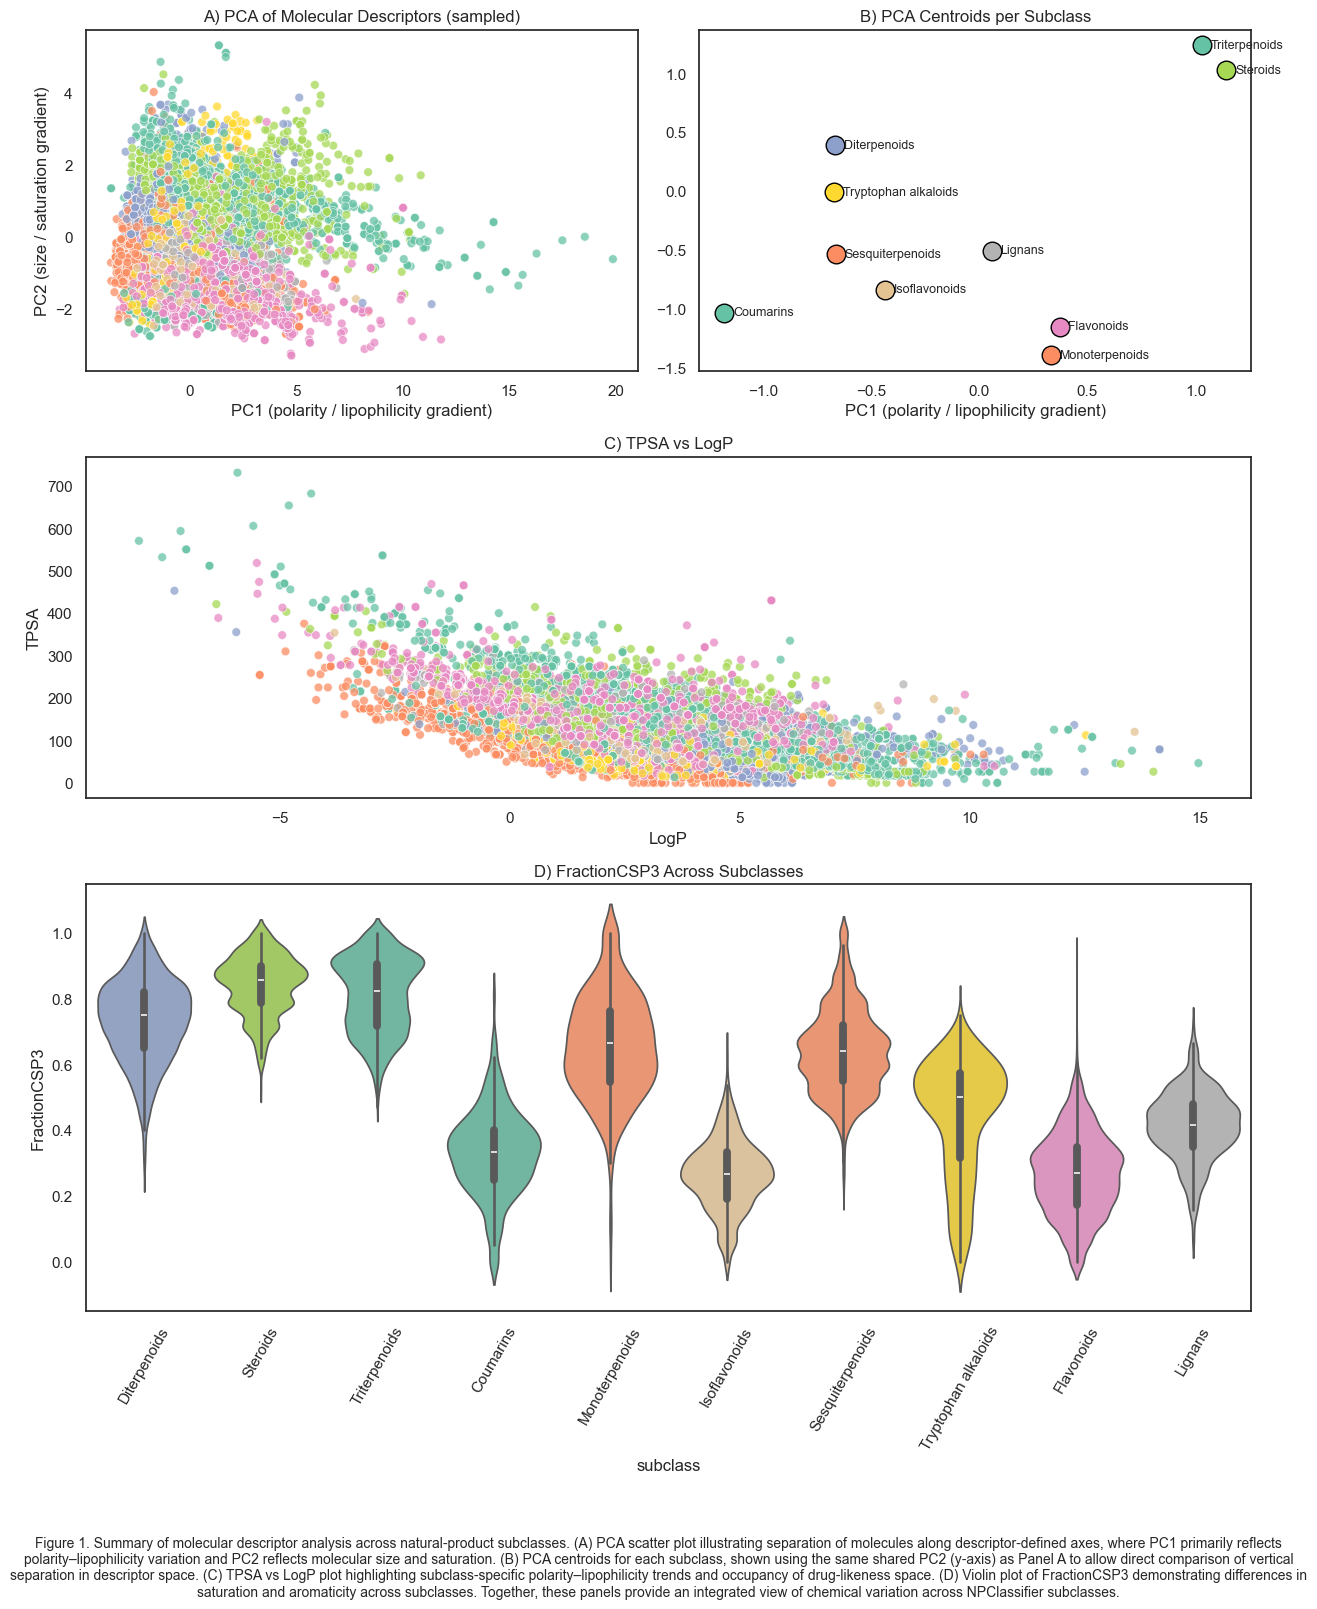

In [6]:
sns.set_theme(style="white")

# -------------------------------------------------------------------------
# 1) PREPARE COLORS
# -------------------------------------------------------------------------
top_sub = df_final["subclass"].value_counts().index[:10]
palette = sns.color_palette("Set2", n_colors=len(top_sub))
color_map = dict(zip(top_sub, palette))

# Subset for plotting
df_plot = df_final[df_final["subclass"].isin(top_sub)].copy()

# PCA prep
desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RingCount", "FractionCSP3"]
X = df_plot[desc_cols].dropna()

X_scaled = StandardScaler().fit_transform(X)
pcs = PCA(n_components=2).fit_transform(X_scaled)

df_pca = df_plot.loc[X.index].copy()
df_pca["PC1"], df_pca["PC2"] = pcs[:, 0], pcs[:, 1]
centroids = df_pca.groupby("subclass")[["PC1", "PC2"]].mean()

# -------------------------------------------------------------------------
# 2) SUMMARY FIGURE (A, B on top; C middle; D bottom)
# -------------------------------------------------------------------------
fig = plt.figure(figsize=(13, 15))

# Grid layout: 3 rows, 2 columns
# Row 1: A (left), B (right)
# Row 2: C (left, full width but using 2 panels visually aligned)
# Row 3: D (full-width violin)

gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 1.5])

# ---------------- Panel A — PCA scatter ----------------
axA = fig.add_subplot(gs[0, 0])
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axA
)
axA.set_title("A) PCA of Molecular Descriptors (sampled)", fontsize=12)
axA.legend_.remove()

# ---------------- Panel B — PCA centroids ----------------
axB = fig.add_subplot(gs[0, 1])
for sub in centroids.index:
    axB.scatter(
        centroids.loc[sub, "PC1"], centroids.loc[sub, "PC2"],
        s=180, color=color_map[sub], edgecolor="black"
    )
    axB.text(
        centroids.loc[sub, "PC1"] + 0.04,
        centroids.loc[sub, "PC2"],
        sub, fontsize=9, va="center"
    )
axB.set_title("B) PCA Centroids per Subclass", fontsize=12)

# ---------------- Panel C — TPSA vs LogP (full width) ----------------
axC = fig.add_subplot(gs[1, :])
sns.scatterplot(
    data=df_plot, x="LogP", y="TPSA",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axC
)
axC.set_title("C) TPSA vs LogP", fontsize=12)
axC.legend_.remove()

# ---------------- Panel D — Violin plot (bottom full width) ----------------
axD = fig.add_subplot(gs[2, :])
sns.violinplot(
    data=df_plot,
    x="subclass",
    y="FractionCSP3",
    palette=color_map,
    ax=axD
)
axD.set_title("D) FractionCSP3 Across Subclasses", fontsize=12)
axD.tick_params(axis='x', rotation=60)

plt.tight_layout()

# -------------------------------------------------------------------------
# 3) CAPTION
# -------------------------------------------------------------------------
caption = (
    "Figure 1. Summary of molecular descriptor analysis across natural-product subclasses. "
    "(A) PCA scatter plot illustrating separation of molecules along descriptor-defined axes, "
    "where PC1 primarily reflects polarity–lipophilicity variation and PC2 reflects molecular "
    "size and saturation. (B) PCA centroids for each subclass, shown using the same shared PC2 "
    "(y-axis) as Panel A to allow direct comparison of vertical separation in descriptor space. "
    "(C) TPSA vs LogP plot highlighting subclass-specific polarity–lipophilicity trends and "
    "occupancy of drug-likeness space. (D) Violin plot of FractionCSP3 demonstrating differences "
    "in saturation and aromaticity across subclasses. Together, these panels provide an integrated "
    "view of chemical variation across NPClassifier subclasses.")

fig.text(
    0.5, -0.03,
    caption,
    ha="center",
    va="top",
    fontsize=10,
    wrap=True
)
axA.set_xlabel("PC1 (polarity / lipophilicity gradient)")
axA.set_ylabel("PC2 (size / saturation gradient)")


axB.set_xlabel("PC1 (polarity / lipophilicity gradient)")


# Save as SVG vector graphic
fig.savefig("chemical_space_summary.svg", format="svg", dpi=300, bbox_inches="tight")

plt.show()
